**MNIST Method Comparison - with convolutions and capsules**   ~ Paul Mooney, December 2017

*Step 1.1: Import Modules*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from PIL import Image
import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn import model_selection
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
%matplotlib inline

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


*Step 1.2: Load Data*

In [2]:
data = pd.read_csv('../input/train.csv')
testingData = pd.read_csv('../input/test.csv')
X = data.drop("label",axis=1).values
y = data.label.values

def describeDataset(features,labels):
    print("\n'X' shape: %s."%(features.shape,))
    print("\n'y' shape: %s."%(labels.shape,))
    print("\nUnique elements in y: %s"%(np.unique(y)))
describeDataset(X,y)


'X' shape: (42000, 784).

'y' shape: (42000,).

Unique elements in y: [0 1 2 3 4 5 6 7 8 9]


*Step 1.3: Display Data*

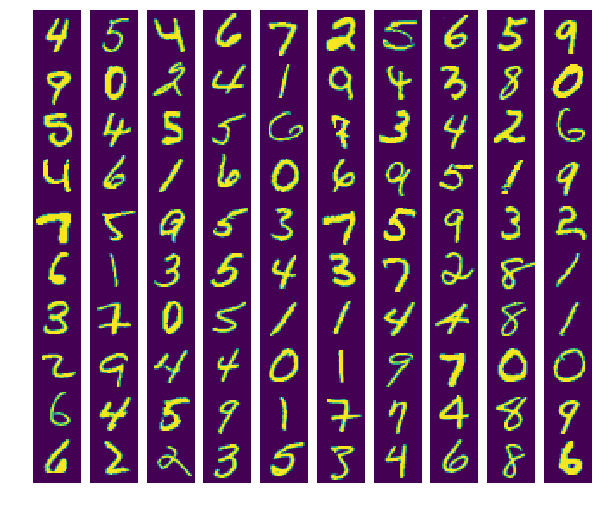

In [3]:
def displayMNIST(flatData,labels):
    """Display MNIST data"""
    flatData2 = data.drop("label",axis=1).values
    X2 = np.insert(flatData2,0,1,axis=1)
    figure,image = plt.subplots(1,10, figsize=(10,10))
    for i in range(10):
        tenImages = np.random.choice(X2.shape[0], 10)
        image[i].imshow(X2[tenImages,1:].reshape(-1,28))
        image[i].axis('off')
displayMNIST(X,y)

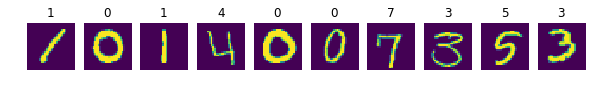

In [4]:
def displayMNIST2(flatData,labels):
    """ Displays 10 handwritten digis and 10 classification labels """
    figure,image = plt.subplots(1,10, figsize=(10,10))
    for i in range(10):
        image[i].imshow(flatData[i].reshape((28,28)))
        image[i].axis('off')
        image[i].set_title(labels[i])
displayMNIST2(X,y)

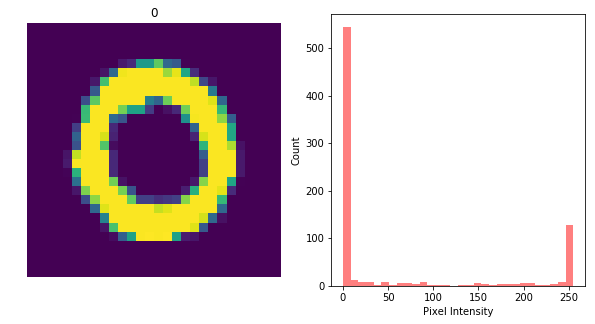

In [5]:
X3 = X[1].reshape((28,28))
def pixelIntensities(flatData,labels):
    """Plot histogram of Pixel Intensities"""
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(flatData)
    plt.axis('off')
    plt.title(labels[1])
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(flatData[:,:].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
pixelIntensities(X3,y)

*Step 2: Preprocess Data*

In [6]:
X = data.iloc[:,1:] # everything but the first column  (pixel values)
y = data.iloc[:,:1] # first column only  (label/answer)

xValues = X
yValues = y.values.ravel()
x_train, x_test, y_train, y_test = train_test_split(xValues, yValues, test_size=0.2, random_state=23)

x_train = x_train/ 256 # normalize values between zero and one
x_test = x_test / 256

# Reshape images from 1D flattened images to normal 2D images
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_trainReshaped = x_train.values.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_testReshaped = x_test.values.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_trainReshaped = x_train.values.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_testReshaped = x_test.values.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_trainReshaped = x_trainReshaped.astype('float32')
x_testReshaped = x_testReshaped.astype('float32')

# convert class vectors to binary class matrices
num_classes = 10
y_trainReshaped = keras.utils.to_categorical(y_train, num_classes)
y_testReshaped = keras.utils.to_categorical(y_test, num_classes)
    
describeDataset(x_trainReshaped,y_trainReshaped)


'X' shape: (33600, 28, 28, 1).

'y' shape: (33600, 10).

Unique elements in y: [0 1 2 3 4 5 6 7 8 9]


*Step 3: Define Helper Functions*

In [7]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

dict_characters = {0: '0', 1: '1', 2: '2', 
        3: '3', 4: '4', 5: '5', 6: '6', 7:'7',
        8: '8', 9: '9'}

*Step 4: Evaluate Standard Classifiers*


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.899881 (0.010493)
RF: 0.902619 (0.008532)
KNN: 0.942500 (0.006368)
SVM: 0.913333 (0.009624)
LSVM: 0.878810 (0.010843)
GNB: 0.565476 (0.018740)
DTC: 0.797976 (0.013469)


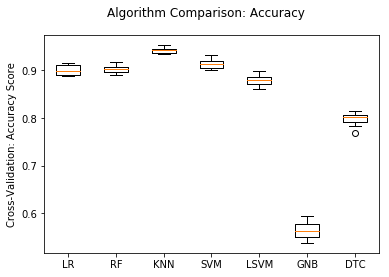

LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine SVC
LSVM = LinearSVC
GNB = GaussianNB
DTC = DecisionTreeClassifier


In [8]:
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):   
    print('\nCompare Multiple Classifiers:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
#    models.append(('GBC', GradientBoostingClassifier()))
#    models.append(('LDA', LinearDiscriminantAnalysis()))  
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a,b)
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        accuracy_results = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)
   
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return

compareABunchOfDifferentModelsAccuracy(x_train,y_train,x_test,y_test)

def defineModels():
    print('LR = LogisticRegression')
    print('RF = RandomForestClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine SVC')
    print('LSVM = LinearSVC')
    print('GNB = GaussianNB')
    print('DTC = DecisionTreeClassifier')
#    print('GBC = GradientBoostingClassifier')
#    print('LDA = LinearDiscriminantAnalysis')
    return
defineModels()

*Step 5: Evaluate Simple Neural Network*

SKlearn Multi-layer Perceptron NN - Training set accuracy: 0.947380952381 (0.00552770798393)



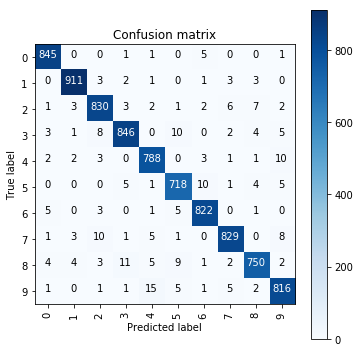

In [9]:
def runMLPCconfusion(a,b,c,d):
    classifier = MLPC()
    classifier.fit(a, b)
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    accuracy = model_selection.cross_val_score(classifier, c, d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('SKlearn Multi-layer Perceptron NN - Training set accuracy: %s (%s)\n' % (mean, stdev))
    prediction = classifier.predict(c)
    cnf_matrix = confusion_matrix(d, prediction)
    np.set_printoptions(precision=2)
    class_names = dict_characters 
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix')
runMLPCconfusion(x_train, y_train,  x_test, y_test)

*Step 6: Evaluate Convolutional Neural Network*

Train on 33600 samples, validate on 8400 samples
Epoch 1/2
33600/33600 [==============================] - 105s 3ms/step - loss: 0.3621 - acc: 0.8884 - val_loss: 0.0829 - val_acc: 0.9742
Epoch 2/2
33600/33600 [==============================] - 105s 3ms/step - loss: 0.1119 - acc: 0.9667 - val_loss: 0.0547 - val_acc: 0.9821

Keras Convolutional Neural Network - accuracy: 0.982142857143 


             precision    recall  f1-score   support

          0       0.98      1.00      0.99       853
          1       0.99      0.98      0.99       924
          2       0.98      0.98      0.98       857
          3       0.98      0.98      0.98       879
          4       0.98      0.98      0.98       810
          5       0.99      0.98      0.98       744
          6       0.99      0.98      0.99       837
          7       0.97      0.98      0.98       858
          8       0.97      0.98      0.98       791
          9       0.98      0.98      0.98       847

avg / total       0.98    

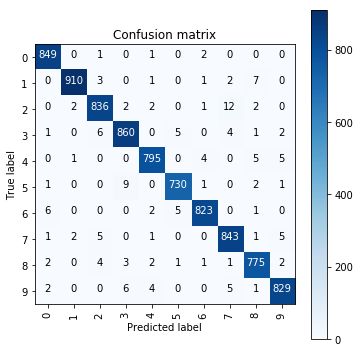

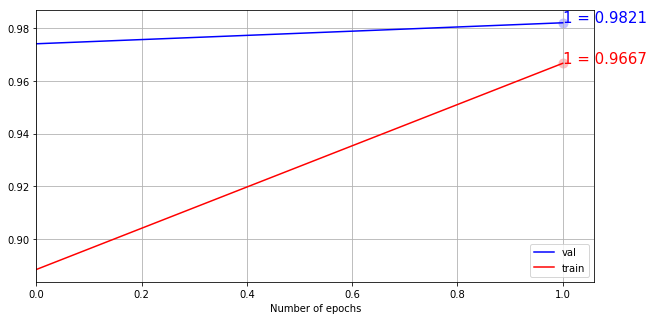

In [10]:
def runKerasCNN(a,b,c,d):
    batch_size = 128
    num_classes = 10
    epochs = 2
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.fit(a, b,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(c,d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras Convolutional Neural Network - accuracy:', score[1],"\n")
    Y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    return model
runKerasCNN(x_trainReshaped, y_trainReshaped,  x_testReshaped, y_testReshaped)
plotKerasLearningCurve()

*Step 7: Add Capsules to Convolutional Neural Network*

Capsules are a relatively new concept (https://arxiv.org/pdf/1710.09829.pdf) and I have not yet taken the time to develop my own implementation.  The functions below that are related to the CapsuleNet are adaptations from https://github.com/XifengGuo/CapsNet-Keras and https://www.kaggle.com/kmader/capsulenet-on-mnist/notebook. It will be interesting to see if the capsule-containing network performs better than the convolutional network above.

*Step 8.1: Define CapsuleNet Helper Functions*

In [11]:
class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        """
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        def body(i, b, outputs):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]

        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        _, _, outputs = tf.while_loop(cond, body, loop_vars)
        """
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
            # tf.summary.histogram('BigBee', self.bias)  # for debugging
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

##############

def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(784, activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=[28, 28, 1], name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])

#########

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

########

# define model
model = CapsNet(input_shape=[28, 28, 1],
                n_class=10,
                num_routing=3)
model.summary()
try:
    plot_model(model, to_file='model.png', show_shapes=True)
except Exception as e:
    print('No fancy plot {}'.format(e))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1152, 8)      0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
lambda_1 (

*Step 8.2: Train CapsuleNet*

In [12]:

def train(model, data, epoch_size_frac=1.0):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger('log.csv')
    checkpoint = callbacks.ModelCheckpoint('weights-{epoch:02d}.h5',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))

    # compile the model
    model.compile(optimizer='adam',
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics={'out_caps': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint])
    """

    # -----------------------------------Begin: Training with data augmentation -----------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, 64, 0.1),
                        steps_per_epoch=int(epoch_size_frac*y_train.shape[0] / 64),
                        epochs=5,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, checkpoint, lr_decay,MetricsCheckpoint('logs')])
    # -----------------------------------End: Training with data augmentation -----------------------------------#

    model.save_weights('trained_model.h5')
    print('Trained model saved to \'trained_model.h5\'')

    return model

######

train(model=model, data=((x_trainReshaped, y_trainReshaped), (x_testReshaped, y_testReshaped)), 
      epoch_size_frac = 0.5) # do 10% of an epoch (takes too long)



Epoch 1/5
262/262 [==============================] - 1603s 6s/step - loss: 0.1926 - out_caps_loss: 0.1926 - out_recon_loss: 0.1914 - out_caps_acc: 0.7895 - val_loss: 0.0459 - val_out_caps_loss: 0.0459 - val_out_recon_loss: 0.0730 - val_out_caps_acc: 0.9712
Epoch 2/5
262/262 [==============================] - 1631s 6s/step - loss: 0.0490 - out_caps_loss: 0.0489 - out_recon_loss: 0.0734 - out_caps_acc: 0.9668 - val_loss: 0.0303 - val_out_caps_loss: 0.0303 - val_out_recon_loss: 0.0678 - val_out_caps_acc: 0.9787
Epoch 3/5
262/262 [==============================] - 1617s 6s/step - loss: 0.0361 - out_caps_loss: 0.0360 - out_recon_loss: 0.0726 - out_caps_acc: 0.9769 - val_loss: 0.0240 - val_out_caps_loss: 0.0240 - val_out_recon_loss: 0.0670 - val_out_caps_acc: 0.9855
Epoch 4/5
262/262 [==============================] - 1607s 6s/step - loss: 0.0286 - out_caps_loss: 0.0286 - out_recon_loss: 0.0716 - out_caps_acc: 0.9806 - val_loss: 0.0245 - val_out_caps_loss: 0.0244 - val_out_recon_loss: 0.0665

*Step 8.3: Evaluate CapsuleNet*

--------------------------------------------------
Test acc: 0.98880952381

Reconstructed images are saved to ./real_and_recon.png
--------------------------------------------------


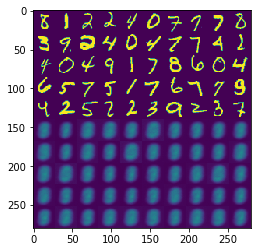

In [13]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

def test(model, data):
    x_test, y_test = data
    y_pred, x_recon = model.predict([x_test, y_test], batch_size=100)
    print('-'*50)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])


    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save("real_and_recon.png")
    print()
    print('Reconstructed images are saved to ./real_and_recon.png')
    print('-'*50)
    plt.imshow(plt.imread("real_and_recon.png", ))
    plt.show()

test(model=model, data=(x_testReshaped, y_testReshaped))


             precision    recall  f1-score   support

          0       1.00      1.00      1.00       853
          1       1.00      0.99      0.99       924
          2       0.98      0.99      0.99       857
          3       1.00      0.98      0.99       879
          4       0.99      0.98      0.99       810
          5       0.97      1.00      0.99       744
          6       0.99      0.99      0.99       837
          7       0.99      0.99      0.99       858
          8       0.99      0.99      0.99       791
          9       0.98      0.98      0.98       847

avg / total       0.99      0.99      0.99      8400



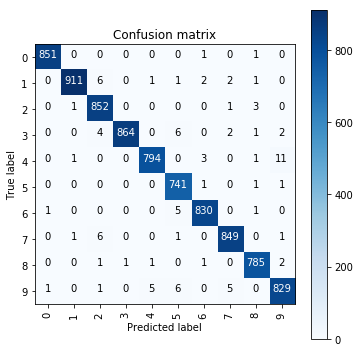

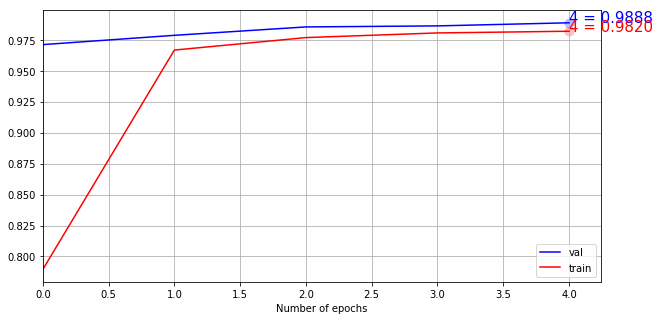

In [14]:
Y_pred, x_recon = model.predict([x_testReshaped, y_testReshaped], batch_size=100)
print('\n', sklearn.metrics.classification_report(np.where(y_testReshaped > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_testReshaped,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plotKerasLearningCurve()

That worked really well!

*Step 9: Submit Results*

In [16]:
data_test = pd.read_csv('../input/test.csv')
data_test = data_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_pred, _ = model.predict([data_test, 
                           np.zeros((data_test.shape[0],10))], # empty values for the second vector 
                           batch_size = 32, verbose = True)

with open('submission.csv', 'w') as out_file:
    out_file.write('ImageId,Label\n')
    for img_id, guess_label in enumerate(np.argmax(y_pred,1),1):
        out_file.write('%d,%d\n' % (img_id, guess_label))

28000/28000 [==============================] - 590s 21ms/step
